# MVDR with PyTorch



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf # For reading audio if needed
import pandas as pd # For data handling
from typing import Dict, Tuple, Any
import torch # Import PyTorch

# Import the ORIGINAL util for calculatePos3d (still NumPy based)
from beamform import util as util_np
# Import the NEW PyTorch versions
from beamform import util_torch
from beamform import mvdr_torch
import audio_generation_torch

# Keep original audio generation for make_mono_audio if not integrating fully
import audio_generation as audio_generation_np


In [2]:
# ================================================
# Setup Device (CPU or GPU if available)
# ================================================
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")
# ================================================


Using CPU


In [ ]:
def get_default_params() -> Dict[str, Any]:
    """Returns a dictionary containing the default parameters for the analysis."""
    params = {
        # Audio Parameters
        "TEST_FREQUENCY": 1000,
        "DURATION": 1.0,
        "SAMPLING_FREQUENCY": 16000,
        "AUDIO_TYPE": "clean",    # Options: 'clean' or 'noisy'
        "SNR_DB": 20,            # Signal-to-Noise Ratio in dB (for noisy audio)

        # STFT Parameters
        "FFT_LENGTH": 512,
        "FFT_SHIFT": 256,
        "FRAME_LENGTH": 512, # Keep equal to FFT_LENGTH for PyTorch STFT/iSTFT

        # Array Geometry Parameters
        "SOUND_SPEED": 343.0,
        "MIC_SPACING": 0.02,
        "NUM_MICS": 8,
        "LOOK_DIRECTION_DEG": 0, # Example: Steer to 30 degrees

        # Analysis Parameters
        "NUM_ANGLES_TO_TEST": 181, # e.g., -90 to +90 in 1 degree steps
        "MIN_ANGLE_DEG": -90,
        "MAX_ANGLE_DEG": 90,

        # MVDR Specific Parameters
        "STABILIZATION_THETA": 1e5,
        "SCM_INIT_FRAMES": 10, # Frames at start for SCM
        "SCM_FINAL_FRAMES": 10, # Frames at end for SCM (Use 0 if only initial noise assumed)

        # Plotting Parameters
        "DB_THRESHOLD": -60,
        "PLOT_TITLE_SUFFIX": " (PyTorch)",
        "FREQ_BIN_FOR_SCM_PLOT": -1 # -1 means calculate based on TEST_FREQUENCY
    }
    params["FRAME_LENGTH"] = params["FFT_LENGTH"] # Ensure consistency

    # Calculate target frequency bin for SCM plot if needed
    if params["FREQ_BIN_FOR_SCM_PLOT"] < 0:
         params["FREQ_BIN_FOR_SCM_PLOT"] = int(params["TEST_FREQUENCY"] * params["FFT_LENGTH"] / params["SAMPLING_FREQUENCY"])

    return params


In [4]:
def generate_test_signal(params: Dict[str, Any]) -> np.ndarray:
    """Generates the mono test audio signal (clean or noisy)."""
    print("\n--- Generating Test Signal ---")
    
    if params["AUDIO_TYPE"].lower() == 'noisy':
        mono_audio = audio_generation_np.make_noisy_mono_audio(
            frequency=params["TEST_FREQUENCY"],
            duration=params["DURATION"],
            sampling_rate=params["SAMPLING_FREQUENCY"],
            snr_db=params["SNR_DB"],
            write_file=False
        )
        print(f"Generated noisy mono audio signal with SNR={params['SNR_DB']}dB: {len(mono_audio)} samples")
    else: # Default to clean audio
        mono_audio = audio_generation_np.make_mono_audio(
            frequency=params["TEST_FREQUENCY"],
            duration=params["DURATION"],
            sampling_rate=params["SAMPLING_FREQUENCY"],
            write_file=False
        )
        print(f"Generated clean mono audio signal: {len(mono_audio)} samples")
    
    # Optional: Plot a sample of the generated audio
    plt.figure(figsize=(10, 4))
    sample_length = min(1000, len(mono_audio))  # Show first 1000 samples or all if fewer
    plt.plot(np.arange(sample_length)/params["SAMPLING_FREQUENCY"], mono_audio[:sample_length])
    plt.title(f"{params['AUDIO_TYPE'].capitalize()} Audio Signal (First {sample_length} samples)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    
    # For comparison, optionally create a spectrogram of the mono signal
    plt.figure(figsize=(10, 4))
    # Correctly unpack the 4 return values from plt.specgram
    _, f, t, _ = plt.specgram(mono_audio, Fs=params["SAMPLING_FREQUENCY"], 
                             NFFT=params["FFT_LENGTH"], noverlap=params["FFT_LENGTH"]-params["FFT_SHIFT"])
    plt.title(f"{params['AUDIO_TYPE'].capitalize()} Mono Signal Spectrogram")
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.show()
    
    return mono_audio


In [5]:
def calculate_array_geometry(params: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates microphone positions and the source position vector (still using NumPy version)."""
    print("\n--- Calculating Array Geometry ---")
    source_position_s, mic_positions_m = util_np.calculatePos3d(
        D=params["MIC_SPACING"],
        M=params["NUM_MICS"],
        theta_degrees=params["LOOK_DIRECTION_DEG"] # Use look direction here
    )
    print(f"Microphone Positions (m):\n{mic_positions_m}")
    print(f"Look Direction Source Position Vector (s) @ r=10m:\n{source_position_s}")
    return source_position_s, mic_positions_m

def plot_array_geometry(mic_positions_m: np.ndarray, source_position_s: np.ndarray, look_direction_deg: float):
    """Plots the microphone array and the look direction source."""
    plt.figure(figsize=(6, 6))
    # Plot mics
    plt.scatter(mic_positions_m[0, :], mic_positions_m[1, :], c='blue', marker='o', label='Microphones')
    # Plot look direction source position
    plt.scatter(source_position_s[0, 0], source_position_s[1, 0], c='red', marker='x', s=100, label=f'Look Direction ({look_direction_deg}°)')

    # Add origin
    plt.scatter(0, 0, c='black', marker='+', s=50, label='Origin')

    # Optional: Draw arrow towards look direction
    plt.arrow(0, 0, source_position_s[0, 0]*0.5, source_position_s[1, 0]*0.5, # Shorter arrow
              head_width=0.01 * np.max(np.abs(mic_positions_m)), head_length=0.02 * np.max(np.abs(mic_positions_m)),
              fc='red', ec='red', length_includes_head=True)


    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.title("Microphone Array Geometry and Look Direction")
    plt.grid(True)
    plt.axis('equal') # Ensure aspect ratio is square
    plt.legend()
    plt.show()

In [6]:
def initialize_beamformer_torch(params: Dict[str, Any], mic_positions_m: np.ndarray) -> mvdr_torch.MinimumVarianceDistortionlessResponseTorch:
    """Initializes the PyTorch MVDR beamformer object."""
    print("\n--- Initializing PyTorch MVDR Beamformer ---")
    mvdr_beamformer = mvdr_torch.MinimumVarianceDistortionlessResponseTorch(
        mic_positions_m=mic_positions_m,
        sampling_frequency=params["SAMPLING_FREQUENCY"],
        sound_speed=params["SOUND_SPEED"],
        fft_length=params["FFT_LENGTH"],
        fft_shift=params["FFT_SHIFT"],
        device=device # Pass the selected device
    )
    print(f"PyTorch MVDR Beamformer Initialized on device: {mvdr_beamformer.device}")
    return mvdr_beamformer

def calculate_look_direction_steering_vector_torch(beamformer: mvdr_torch.MinimumVarianceDistortionlessResponseTorch,
                                                   source_position_s: np.ndarray) -> torch.Tensor:
    """Calculates the steering vector for the desired look direction using PyTorch."""
    print("\n--- Calculating Look Direction Steering Vector (PyTorch) ---")
    # Beamformer method now takes NumPy array and returns Tensor on device
    steering_vector_look_direction = beamformer.get_steering_vector_torch(source_position_s)
    print(f"Calculated steering vector tensor for look direction. Shape: {steering_vector_look_direction.shape}, Device: {steering_vector_look_direction.device}")
    return steering_vector_look_direction


def plot_stft(complex_spectrum_tensor: torch.Tensor, params: Dict[str, Any], title_suffix: str = ""):
    """Plots the magnitude STFT for each channel."""
    # Move tensor to CPU and convert to NumPy for plotting
    spec_np = complex_spectrum_tensor.abs().cpu().numpy() # Shape [channels, bins, frames]
    num_channels, num_bins, num_frames = spec_np.shape

    plt.figure(figsize=(12, num_channels * 2))
    # Calculate time and frequency axes
    time_axis = np.linspace(0, num_frames * params["FFT_SHIFT"] / params["SAMPLING_FREQUENCY"], num_frames)
    freq_axis = np.linspace(0, params["SAMPLING_FREQUENCY"] / 2, num_bins)

    for ch in range(num_channels):
        plt.subplot(num_channels, 1, ch + 1)
        plt.pcolormesh(time_axis, freq_axis, 20 * np.log10(spec_np[ch, :, :] + 1e-9), cmap='viridis', shading='gouraud')
        plt.title(f'Channel {ch} Magnitude Spectrogram {title_suffix}')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()
    
    
def plot_scm(scm_tensor: torch.Tensor, freq_bin_index: int, params: Dict[str, Any]):
    """Plots the magnitude and phase of the SCM at a specific frequency bin."""
    if freq_bin_index >= scm_tensor.shape[2]:
        print(f"Error: Frequency bin index {freq_bin_index} is out of bounds (max: {scm_tensor.shape[2]-1}).")
        return

    # Move tensor to CPU and convert to NumPy for plotting
    scm_f_np = scm_tensor[:, :, freq_bin_index].cpu().numpy() # Shape [mic, mic]

    freq_hz = freq_bin_index * params["SAMPLING_FREQUENCY"] / params["FFT_LENGTH"]

    plt.figure(figsize=(12, 5))

    # Magnitude
    plt.subplot(1, 2, 1)
    mag_db = 20 * np.log10(np.abs(scm_f_np) + 1e-9)
    im = plt.imshow(mag_db, cmap='viridis', origin='lower')
    plt.title(f'SCM Magnitude (dB) at {freq_hz:.1f} Hz (Bin {freq_bin_index})')
    plt.xlabel('Microphone Index')
    plt.ylabel('Microphone Index')
    plt.colorbar(im, label='Magnitude (dB)')

    # Phase
    plt.subplot(1, 2, 2)
    phase = np.angle(scm_f_np)
    im = plt.imshow(phase, cmap='hsv', origin='lower', vmin=-np.pi, vmax=np.pi)
    plt.title(f'SCM Phase (radians) at {freq_hz:.1f} Hz (Bin {freq_bin_index})')
    plt.xlabel('Microphone Index')
    plt.ylabel('Microphone Index')
    plt.colorbar(im, label='Phase (rad)')

    plt.tight_layout()
    plt.show()


def plot_weights(weights_tensor: torch.Tensor, params: Dict[str, Any]):
    """Plots the magnitude and phase of the beamformer weights."""
    # Move tensor to CPU and convert to NumPy for plotting
    weights_np = weights_tensor.cpu().numpy() # Shape [mic, bin]
    num_mics, num_bins = weights_np.shape
    freq_axis = np.linspace(0, params["SAMPLING_FREQUENCY"] / 2, num_bins)

    plt.figure(figsize=(12, 8))

    # Magnitude
    plt.subplot(2, 1, 1)
    for i in range(num_mics):
        plt.plot(freq_axis, 20 * np.log10(np.abs(weights_np[i, :]) + 1e-9), label=f'Mic {i}')
    plt.title(f"Beamformer Weights Magnitude (Look={params['LOOK_DIRECTION_DEG']}°)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight Magnitude (dB)")
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(bottom=params['DB_THRESHOLD'] - 10) # Adjust y-limit based on threshold

    # Phase
    plt.subplot(2, 1, 2)
    for i in range(num_mics):
        plt.plot(freq_axis, np.angle(weights_np[i, :]), label=f'Mic {i}')
    plt.title(f"Beamformer Weights Phase (Look={params['LOOK_DIRECTION_DEG']}°)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight Phase (radians)")
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
    plt.show()


In [7]:
def run_beam_pattern_analysis_torch(params: Dict[str, Any],
                                    mono_audio: np.ndarray,
                                    beamformer: mvdr_torch.MinimumVarianceDistortionlessResponseTorch,
                                    steering_vector_look_direction: torch.Tensor) -> Dict[str, Any]:
    """Runs the main analysis loop using PyTorch."""
    print(f"\n--- Starting PyTorch Analysis Loop ({params['NUM_ANGLES_TO_TEST']} angles) ---")
    angle_degrees_arr = []
    log_output_arr = []
    angle_rad_arr = []

    max_angle_response = -np.inf
    max_val_response = -np.inf

    num_angles = params["NUM_ANGLES_TO_TEST"]
    min_angle = params["MIN_ANGLE_DEG"]
    max_angle = params["MAX_ANGLE_DEG"]

    # Store SCM and weights for the look direction for plotting later
    scm_look_direction = None
    weights_look_direction = None
    stft_look_direction = None

    # --- Use torch.no_grad() for inference ---
    with torch.no_grad():
        for i in range(num_angles):
            incident_angle_deg = min_angle + (max_angle - min_angle) * (i / max(1, num_angles - 1))
            incident_angle_rad = np.radians(incident_angle_deg)

            # 1. Simulate multi-channel audio (using PyTorch version)
            # Output is NumPy [samples, channels]
            multi_channel_audio_np = audio_generation_torch.delay_across_channels_torch(
                mono_audio,
                incident_angle_deg,
                params["NUM_MICS"],
                params["MIC_SPACING"],
                params["SAMPLING_FREQUENCY"],
                params["SOUND_SPEED"],
                device=device # Perform simulation FFTs on the target device
            )
            # Convert to Tensor [channels, samples] for beamformer processing
            multi_channel_tensor = torch.from_numpy(multi_channel_audio_np.T).to(device).float()

            # 2. Calculate STFT (using PyTorch version)
            # Returns Tensor [channels, bins, frames] on device
            complex_spectrum_tensor, _ = util_torch.get_3dim_spectrum_torch(
                 multi_channel_audio_np, # Pass NumPy array [samples, channels]
                 params["FRAME_LENGTH"],
                 params["FFT_SHIFT"],
                 params["FFT_LENGTH"],
                 device=device
            )
            if complex_spectrum_tensor is None:
                print(f"Skipping angle {incident_angle_deg:.1f} due to STFT error.")
                continue

            # 3. Estimate SCM (using PyTorch version)
            # Expects Tensor [channels, samples] -> use multi_channel_tensor
            # Returns Tensor [channels, channels, bins] on device
            spatial_correlation_matrix = beamformer.get_spatial_correlation_matrix_torch(
                multi_channel_tensor,
                params["SCM_INIT_FRAMES"],
                params["SCM_FINAL_FRAMES"]
            )

            # 4. Calculate MVDR weights (using PyTorch version)
            # Requires steering vector (Tensor) and SCM (Tensor)
            # Returns Tensor [channels, bins] on device
            beamformer_weights = beamformer.get_mvdr_beamformer_torch(
                steering_vector_look_direction,
                spatial_correlation_matrix,
                params["STABILIZATION_THETA"]
            )

            # --- Store results for look direction ---
            if abs(incident_angle_deg - params["LOOK_DIRECTION_DEG"]) < 1e-6:
                 scm_look_direction = spatial_correlation_matrix.clone()
                 weights_look_direction = beamformer_weights.clone()
                 stft_look_direction = complex_spectrum_tensor.clone()
            # -----------------------------------------

            # 5. Apply beamformer weights to the spectrum
            # Y(f, t) = w(f)^H * X(f, t) -> Y[bin, frame]
            # w weights: [channels, bins]
            # X spectrum: [channels, bins, frames]
            weights_conj = beamformer_weights.conj() # [channels, bins]
            # einsum: 'cb, cbf -> bf' (c=channels, b=bins, f=frames)
            enhanced_speech_spectrum = torch.einsum('cb, cbf -> bf', weights_conj, complex_spectrum_tensor)
            # Result shape: [bins, frames]

            # 6. Calculate output power/amplitude (using PyTorch tensors)
            # Average power across frames and bins
            # Power = |Y|^2
            power_per_frame_bin = torch.abs(enhanced_speech_spectrum)**2
            # Average over frames (dim=1), then over bins (dim=0) - or just mean over all
            average_output_power = torch.mean(power_per_frame_bin)
            output_amplitude = torch.sqrt(average_output_power)

            # Convert to log scale (still on device)
            if output_amplitude < 1e-9:
                 log_output_tensor = torch.tensor(params["DB_THRESHOLD"], device=device, dtype=torch.float32)
            else:
                 log_output_tensor = 20 * torch.log10(output_amplitude)

            log_output_tensor = torch.clamp(log_output_tensor, min=params["DB_THRESHOLD"])

            # Store results (move scalar log output to CPU and convert to float)
            angle_rad_arr.append(incident_angle_rad)
            angle_degrees_arr.append(incident_angle_deg)
            log_output_arr.append(log_output_tensor.item()) # .item() gets Python float

            # Track maximum response
            current_log_output = log_output_tensor.item()
            if current_log_output > max_val_response:
                max_val_response = current_log_output
                max_angle_response = incident_angle_deg

            if (i + 1) % 20 == 0 or num_angles < 20:
                print(f"Processed angle {i+1}/{num_angles} ({incident_angle_deg:.1f} degrees)")

    print("\nAnalysis complete.")
    print(f"Maximum response was {max_val_response:.2f} dB at {max_angle_response:.2f} degrees.")

    return {
        "angles_deg": np.array(angle_degrees_arr),
        "angles_rad": np.array(angle_rad_arr),
        "log_outputs": np.array(log_output_arr),
        "max_val_response": max_val_response,
        "max_angle_response": max_angle_response,
        # Add the stored tensors for plotting
        "scm_look_direction": scm_look_direction,
        "weights_look_direction": weights_look_direction,
        "stft_look_direction": stft_look_direction
    }

def plot_beam_pattern(params: Dict[str, Any], analysis_results: Dict[str, Any]):
    """Generates polar and Cartesian plots of the beam pattern (no changes needed)."""
    print("\n--- Plotting Beam Pattern Results ---")
    angles_deg = analysis_results["angles_deg"]
    angles_rad = analysis_results["angles_rad"]
    log_outputs = analysis_results["log_outputs"]
    max_val_response = analysis_results["max_val_response"]
    db_threshold = params["DB_THRESHOLD"]

    if len(angles_deg) == 0:
        print("No results to plot.")
        return

    # Normalize
    normalized_log_output = log_outputs - max_val_response
    plot_threshold = db_threshold - max_val_response
    normalized_log_output_clipped = np.maximum(normalized_log_output, plot_threshold)

    title_base = (f"MVDR Beam Pattern (Look={params['LOOK_DIRECTION_DEG']}°, "
                  f"Freq={params['TEST_FREQUENCY']} Hz)")
    title_full = title_base + params.get("PLOT_TITLE_SUFFIX", "")

    # --- Polar Plot ---
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.plot(angles_rad, normalized_log_output_clipped, 'b-')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(params["MIN_ANGLE_DEG"])
    ax.set_thetamax(params["MAX_ANGLE_DEG"])
    ax.set_rlim([plot_threshold, 0])
    ax.set_rticks(np.linspace(plot_threshold, 0, 6))
    ax.set_rlabel_position(90)
    plt.title(title_full + "\nPolar Plot")
    ax.grid(True)
    plt.show()

    # --- Cartesian Plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(angles_deg, normalized_log_output_clipped, 'b-')
    plt.xlabel("Incident Angle (degrees)")
    plt.ylabel("Beamformer Response (dB relative to max)")
    plt.title(title_full + "\nCartesian Plot")
    plt.ylim([plot_threshold - 5, 5])
    plt.xlim([params["MIN_ANGLE_DEG"], params["MAX_ANGLE_DEG"]])
    plt.grid(True)
    plt.show()


In [8]:
def final_output(params):
    # 2. Generate Test Signal
    mono_audio_signal = generate_test_signal(params)

    # 3. Calculate Array Geometry
    look_direction_s, mic_positions = calculate_array_geometry(params)

    # +++ Plot Array Geometry +++
    plot_array_geometry(mic_positions, look_direction_s, params["LOOK_DIRECTION_DEG"])

    # 4. Initialize PyTorch Beamformer
    mvdr_bf_torch = initialize_beamformer_torch(params, mic_positions)

    # 5. Calculate Steering Vector for Look Direction
    sv_look_direction_torch = calculate_look_direction_steering_vector_torch(mvdr_bf_torch, look_direction_s)

    # 6. Run Analysis Loop (PyTorch version)
    analysis_output = run_beam_pattern_analysis_torch(
        params,
        mono_audio_signal,
        mvdr_bf_torch,
        sv_look_direction_torch
    )

    # 7. Plot Beam Pattern
    plot_beam_pattern(params, analysis_output)

    # +++ Plot Additional Details (STFT, SCM, Weights for Look Direction) +++
    print("\n--- Plotting Details for Look Direction ---")
    if analysis_output.get("stft_look_direction") is not None:
        plot_stft(analysis_output["stft_look_direction"], params, f"(Input @ Look Direction {params['LOOK_DIRECTION_DEG']}°)")
    else:
        print("STFT data for look direction not available.")

    if analysis_output.get("scm_look_direction") is not None:
        plot_scm(analysis_output["scm_look_direction"], params["FREQ_BIN_FOR_SCM_PLOT"], params)
    else:
        print("SCM data for look direction not available.")

    if analysis_output.get("weights_look_direction") is not None:
        plot_weights(analysis_output["weights_look_direction"], params)
    else:
        print("Weights data for look direction not available.")

    print("\n--- Analysis Finished ---")

In [ ]:
# --- Configuration for the current run ---
params = get_default_params()

# --- MODIFY PARAMETERS FOR EXPERIMENTATION HERE (base values for now) ---

# Audio Parameters
params["TEST_FREQUENCY"] = 1000      # Hz (Frequency of the test sine wave)
params["DURATION"] = 1.0             # seconds (Duration of the test signal)
params["SAMPLING_FREQUENCY"] = 16000 # Hz (Ensure this matches MVDR setup)
params["AUDIO_TYPE"] = "clean"      # Options: 'clean' or 'noisy'
params["SNR_DB"] = 20               # Signal-to-Noise Ratio in dB (for noisy audio)

# STFT Parameters (Should match MVDR setup)
params["FFT_LENGTH"] = 512           # FFT length
params["FFT_SHIFT"] = 256            # 50% overlap is common
params["FRAME_LENGTH"] = params["FFT_LENGTH"] 

# Array Geometry Parameters
params["SOUND_SPEED"] = 343.0   # m/s
params["MIC_SPACING"] = 0.02    # meters
params["NUM_MICS"] = 8
params["LOOK_DIRECTION_DEG"] = 5  # degrees (Angle beamformer is steered towards, 0=broadside)

# Analysis Parameters
params["NUM_ANGLES_TO_TEST"] = 500 # Number of points for the polar plot
params["MIN_ANGLE_DEG"] = -90
params["MAX_ANGLE_DEG"] = 90

# MVDR Specific Parameters
params["STABILIZATION_THETA"] = 1e5 # Condition number threshold for SCM stabilization

# Plotting Parameters
params["DB_THRESHOLD"] = -50      # Minimum dB value for plotting
params["PLOT_TITLE_SUFFIX"] = " (PyTorch)"   # Optional suffix for plot titles

print("Using parameters:")
for key, value in params.items():
    print(f"- {key}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- AUDIO_TYPE: clean
- SNR_DB: 20
- FFT_LENGTH: 512
- FFT_SHIFT: 256
- FRAME_LENGTH: 512
- SOUND_SPEED: 343.0
- MIC_SPACING: 0.04
- NUM_MICS: 8
- LOOK_DIRECTION_DEG: 5
- NUM_ANGLES_TO_TEST: 500
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- STABILIZATION_THETA: 100000.0
- SCM_INIT_FRAMES: 10
- SCM_FINAL_FRAMES: 10
- DB_THRESHOLD: -50
- PLOT_TITLE_SUFFIX:  (PyTorch)
- FREQ_BIN_FOR_SCM_PLOT: 32



--- Generating Test Signal ---
Generated clean mono audio signal: 16000 samples


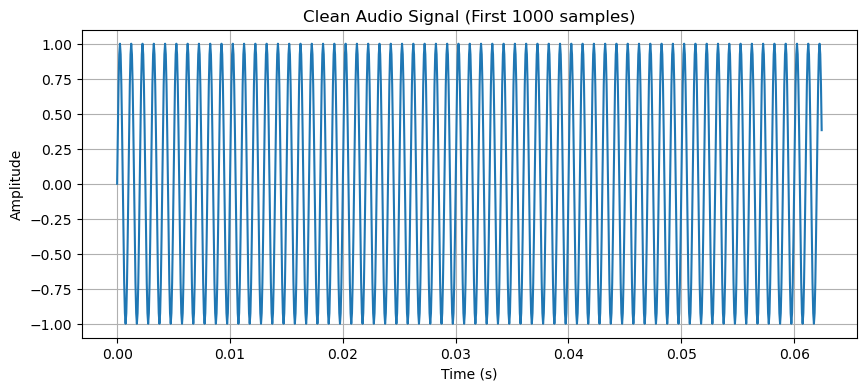

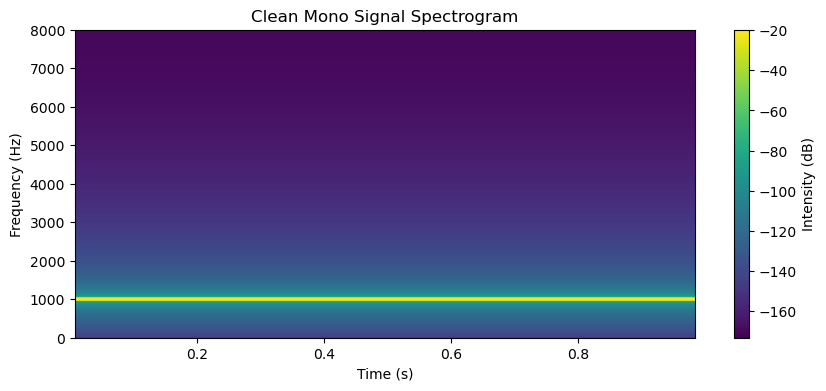


--- Calculating Array Geometry ---
(ULA assumption).
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
Look Direction Source Position Vector (s) @ r=10m:
[[0.87155743]
 [9.96194698]
 [0.        ]]


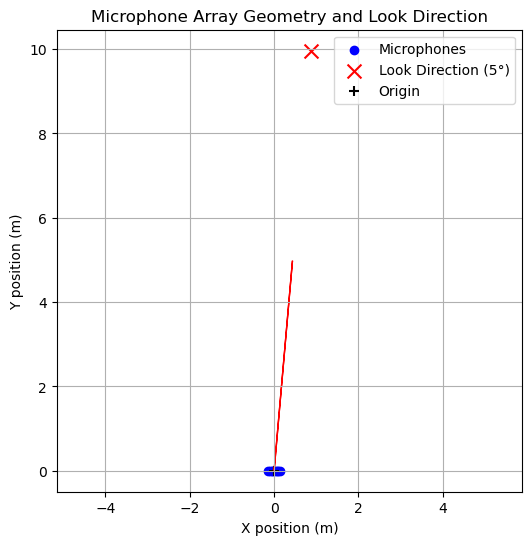


--- Initializing PyTorch MVDR Beamformer ---
PyTorch MVDR Beamformer Initialized on device: cpu

--- Calculating Look Direction Steering Vector (PyTorch) ---
Calculated steering vector tensor for look direction. Shape: torch.Size([8, 257]), Device: cpu

--- Starting PyTorch Analysis Loop (500 angles) ---
Processed angle 20/500 (-83.1 degrees)
Processed angle 20/500 (-83.1 degrees)
Processed angle 40/500 (-75.9 degrees)
Processed angle 40/500 (-75.9 degrees)
Processed angle 60/500 (-68.7 degrees)
Processed angle 60/500 (-68.7 degrees)
Processed angle 80/500 (-61.5 degrees)
Processed angle 80/500 (-61.5 degrees)
Processed angle 100/500 (-54.3 degrees)
Processed angle 100/500 (-54.3 degrees)
Processed angle 120/500 (-47.1 degrees)
Processed angle 120/500 (-47.1 degrees)
Processed angle 140/500 (-39.9 degrees)
Processed angle 140/500 (-39.9 degrees)
Processed angle 160/500 (-32.6 degrees)
Processed angle 160/500 (-32.6 degrees)
Processed angle 180/500 (-25.4 degrees)
Processed angle 180/5

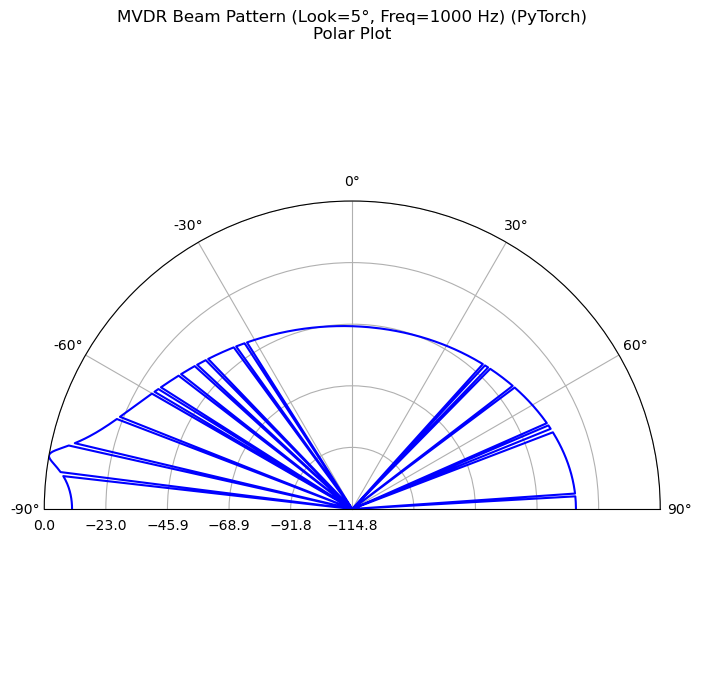

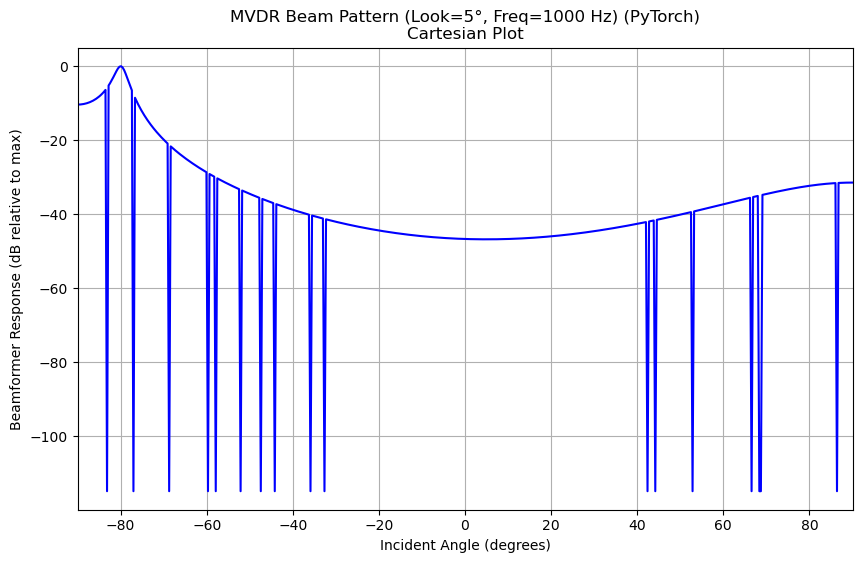


--- Plotting Details for Look Direction ---
STFT data for look direction not available.
SCM data for look direction not available.
Weights data for look direction not available.

--- Analysis Finished ---


In [10]:
final_output(params)

In [ ]:
# --- Configuration for the current run ---
params = get_default_params()

# STFT Parameters (Should match MVDR setup)
params["FFT_LENGTH"] = 256           # FFT length
params["FFT_SHIFT"] = 128            # 50% overlap is common
params["FRAME_LENGTH"] = params["FFT_LENGTH"] 

params["LOOK_DIRECTION_DEG"] = 5  # degrees (Angle beamformer is steered towards, 0=broadside)
params["AUDIO_TYPE"] = "clean"    # Try with noisy audio
params["SNR_DB"] = 10             # Lower SNR for more challenging conditions

params["MIC_SPACING"] = 0.02

print("Using parameters:")
for key, value in params.items():
    print(f"- {key}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- AUDIO_TYPE: clean
- SNR_DB: 10
- FFT_LENGTH: 256
- FFT_SHIFT: 128
- FRAME_LENGTH: 256
- SOUND_SPEED: 343.0
- MIC_SPACING: 0.0125
- NUM_MICS: 8
- LOOK_DIRECTION_DEG: 5
- NUM_ANGLES_TO_TEST: 181
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- STABILIZATION_THETA: 100000.0
- SCM_INIT_FRAMES: 10
- SCM_FINAL_FRAMES: 10
- DB_THRESHOLD: -60
- PLOT_TITLE_SUFFIX:  (PyTorch)
- FREQ_BIN_FOR_SCM_PLOT: 32



--- Generating Test Signal ---
Generated clean mono audio signal: 16000 samples


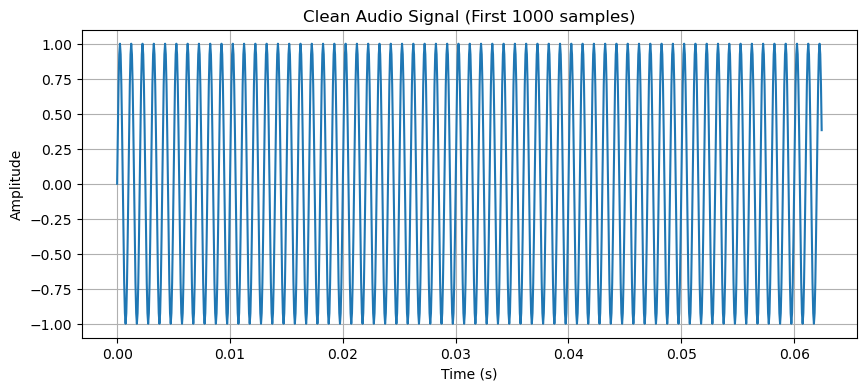

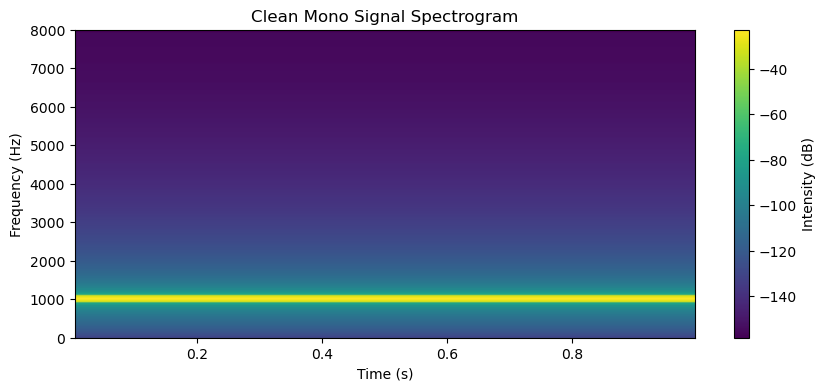


--- Calculating Array Geometry ---
(ULA assumption).
Microphone Positions (m):
[[-0.04375 -0.03125 -0.01875 -0.00625  0.00625  0.01875  0.03125  0.04375]
 [ 0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.     ]]
Look Direction Source Position Vector (s) @ r=10m:
[[0.87155743]
 [9.96194698]
 [0.        ]]


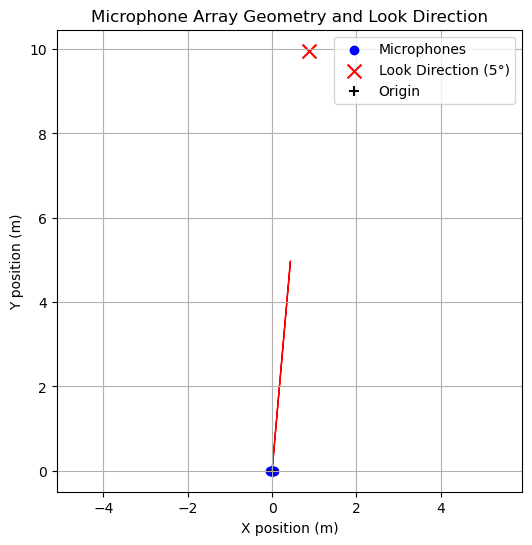


--- Initializing PyTorch MVDR Beamformer ---
PyTorch MVDR Beamformer Initialized on device: cpu

--- Calculating Look Direction Steering Vector (PyTorch) ---
Calculated steering vector tensor for look direction. Shape: torch.Size([8, 129]), Device: cpu

--- Starting PyTorch Analysis Loop (181 angles) ---
Processed angle 20/181 (-71.0 degrees)
Processed angle 40/181 (-51.0 degrees)
Processed angle 60/181 (-31.0 degrees)
Processed angle 80/181 (-11.0 degrees)
Processed angle 100/181 (9.0 degrees)
Processed angle 120/181 (29.0 degrees)
Processed angle 140/181 (49.0 degrees)
Processed angle 160/181 (69.0 degrees)
Processed angle 180/181 (89.0 degrees)

Analysis complete.
Maximum response was 14.94 dB at 5.00 degrees.

--- Plotting Beam Pattern Results ---


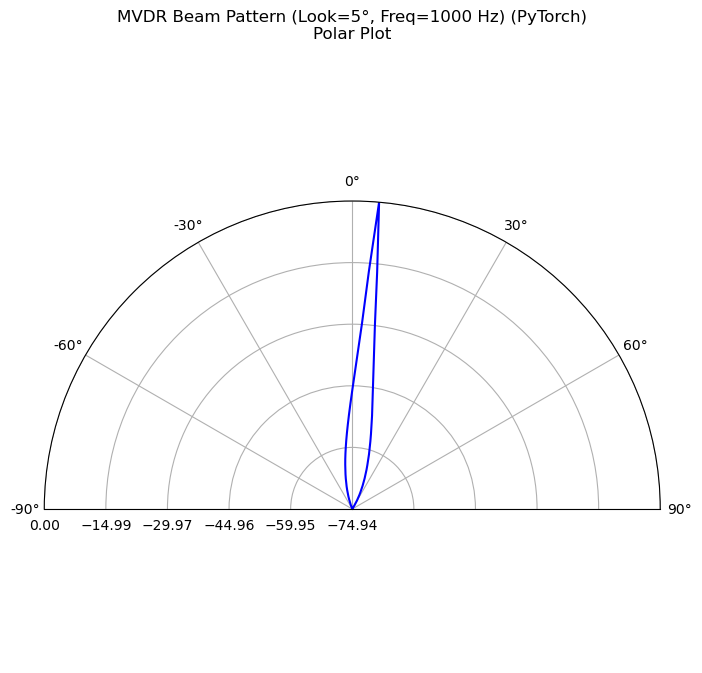

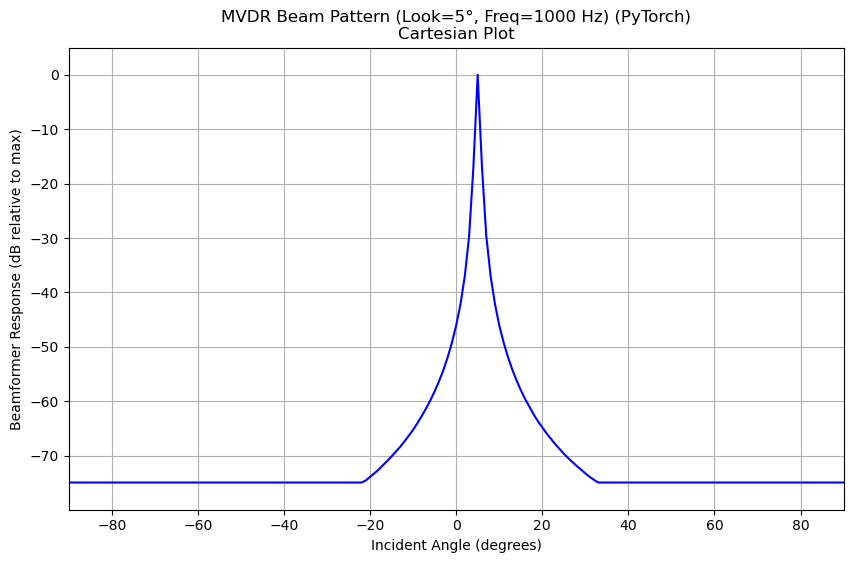


--- Plotting Details for Look Direction ---


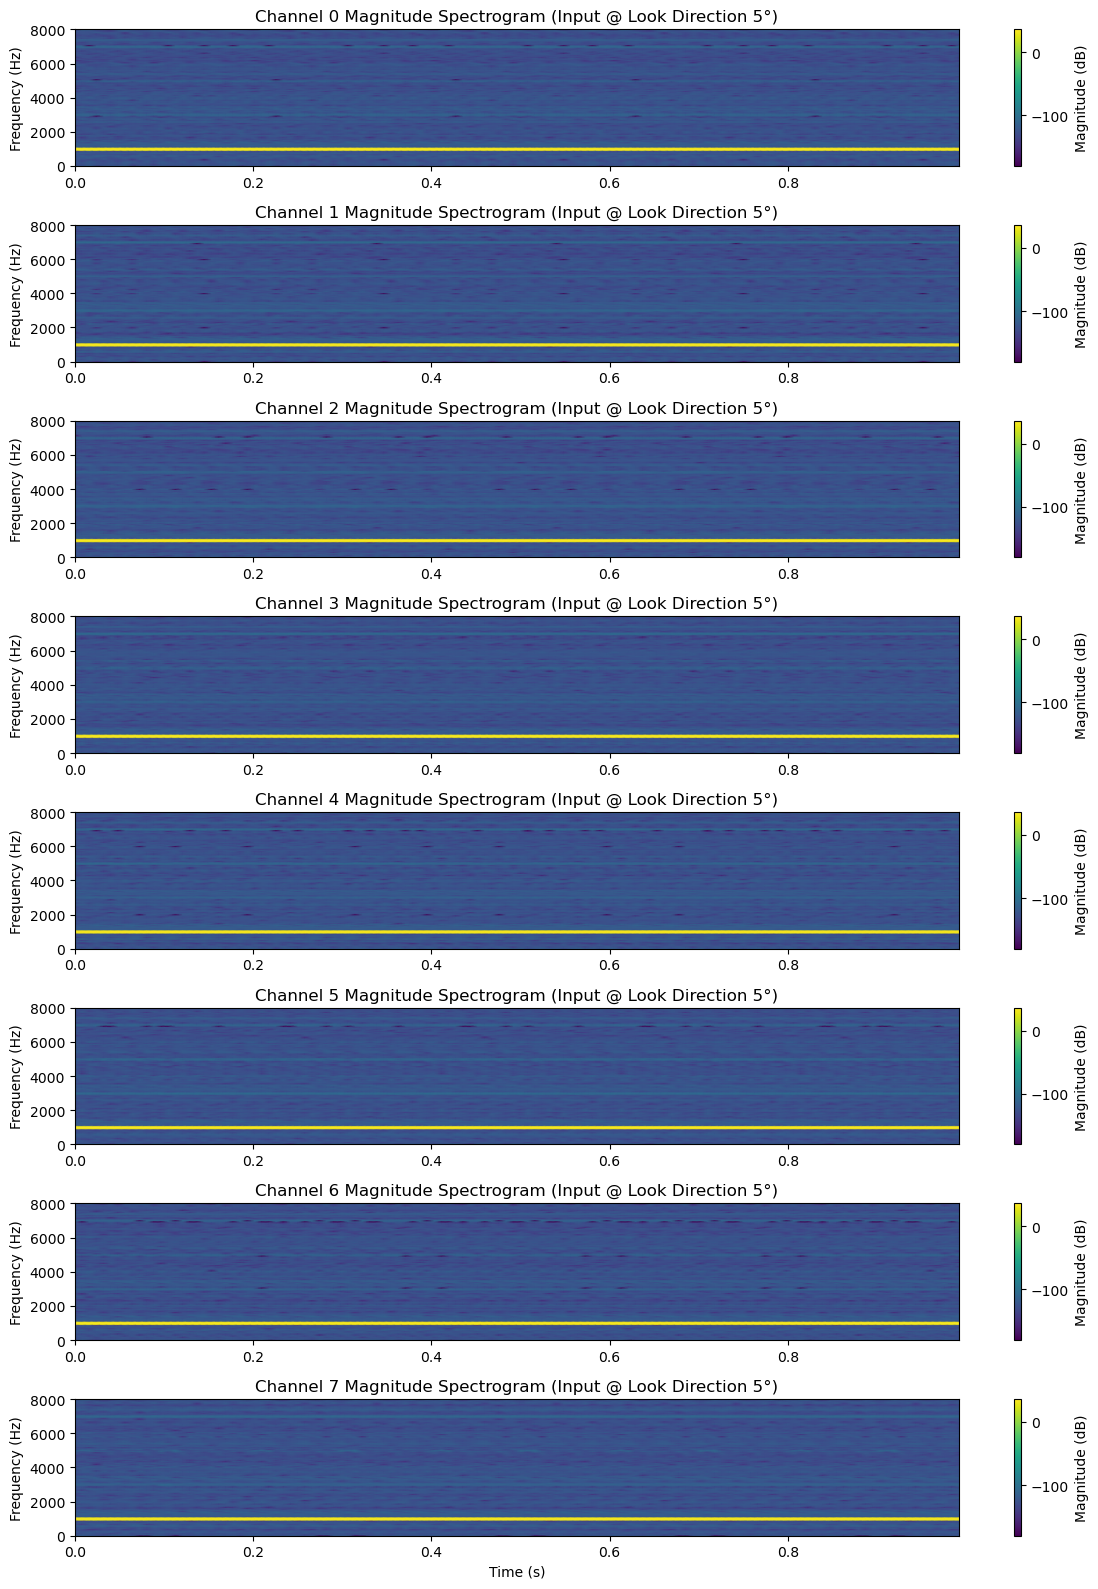

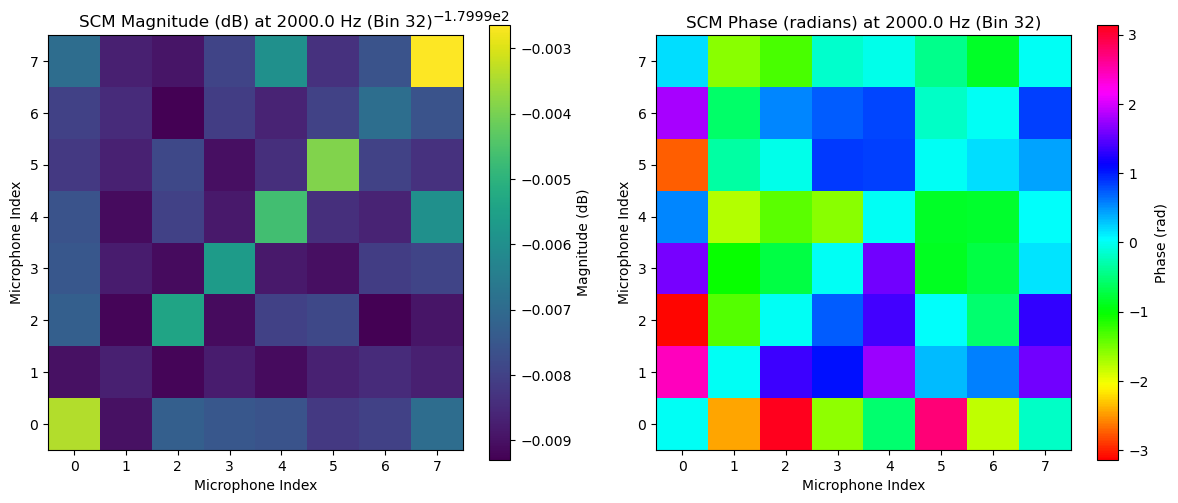

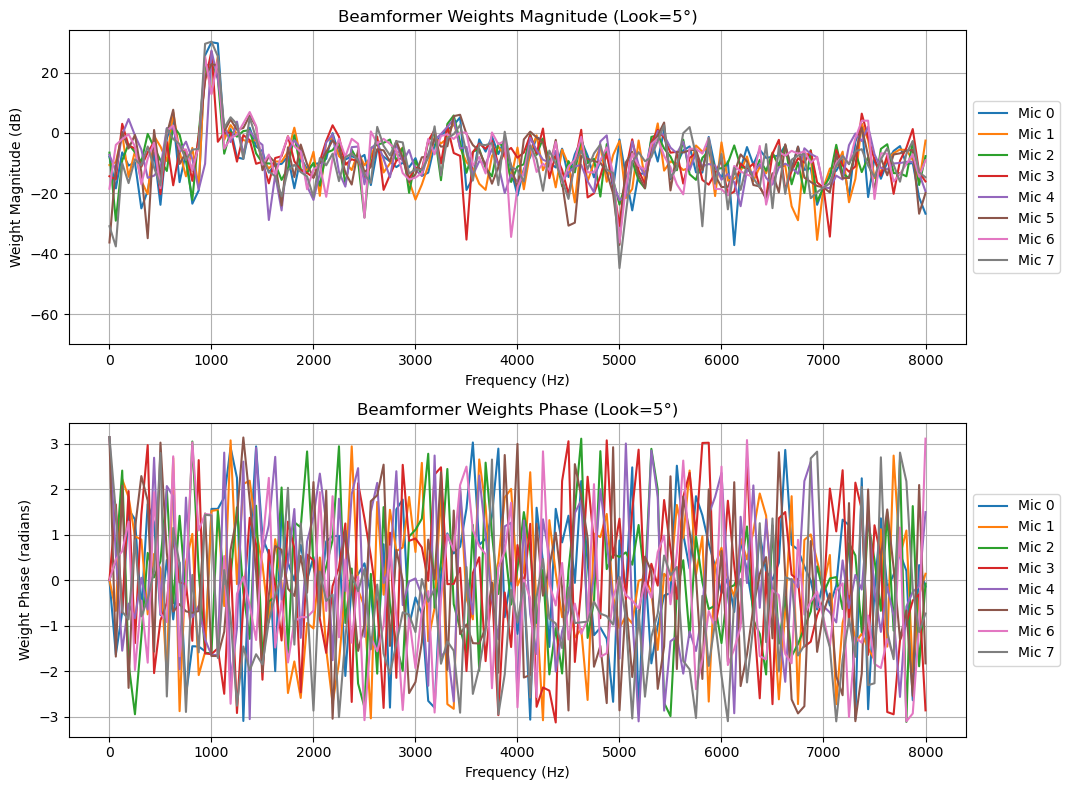


--- Analysis Finished ---


In [ ]:
final_output(params), # calculate diff test freq, mic spacing smaller

In [13]:
# --- Configuration for the current run ---
params = get_default_params()

# --- MODIFY PARAMETERS FOR EXPERIMENTATION HERE (base values for now) ---

# STFT Parameters (Should match MVDR setup)
params["FFT_LENGTH"] = 256           # FFT length
params["FFT_SHIFT"] = 128            # 50% overlap is common
params["FRAME_LENGTH"] = params["FFT_LENGTH"] 

params["LOOK_DIRECTION_DEG"] = -5  # degrees (Angle beamformer is steered towards, 0=broadside)


print("Using parameters:")
for key, value in params.items():
    print(f"- {key}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- AUDIO_TYPE: clean
- SNR_DB: 20
- FFT_LENGTH: 256
- FFT_SHIFT: 128
- FRAME_LENGTH: 256
- SOUND_SPEED: 343.0
- MIC_SPACING: 0.04
- NUM_MICS: 8
- LOOK_DIRECTION_DEG: -5
- NUM_ANGLES_TO_TEST: 181
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- STABILIZATION_THETA: 100000.0
- SCM_INIT_FRAMES: 10
- SCM_FINAL_FRAMES: 10
- DB_THRESHOLD: -60
- PLOT_TITLE_SUFFIX:  (PyTorch)
- FREQ_BIN_FOR_SCM_PLOT: 32



--- Generating Test Signal ---
Generated clean mono audio signal: 16000 samples


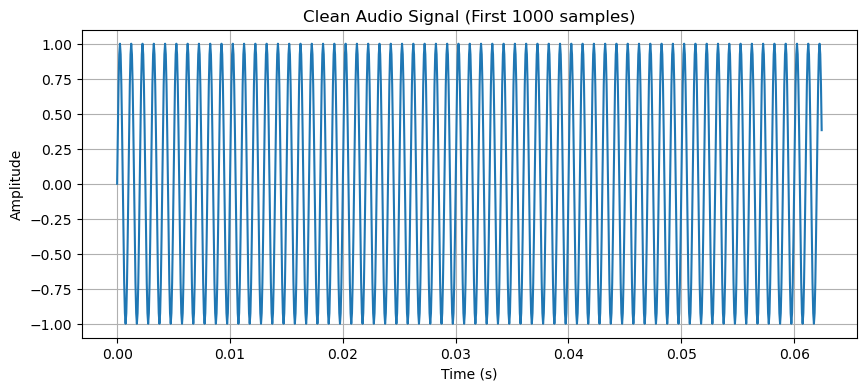

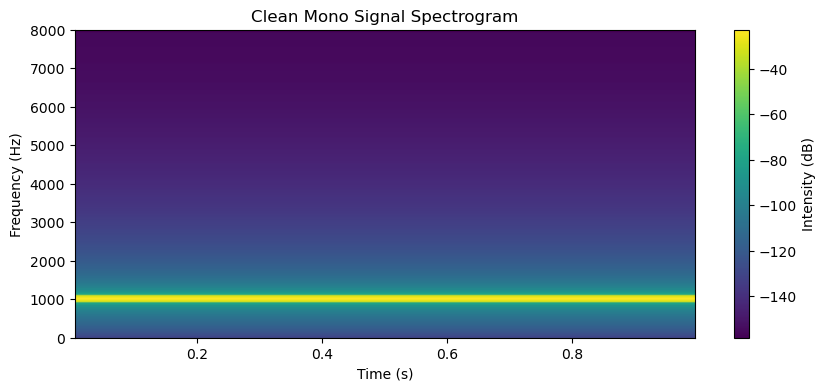


--- Calculating Array Geometry ---
(ULA assumption).
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
Look Direction Source Position Vector (s) @ r=10m:
[[-0.87155743]
 [ 9.96194698]
 [ 0.        ]]


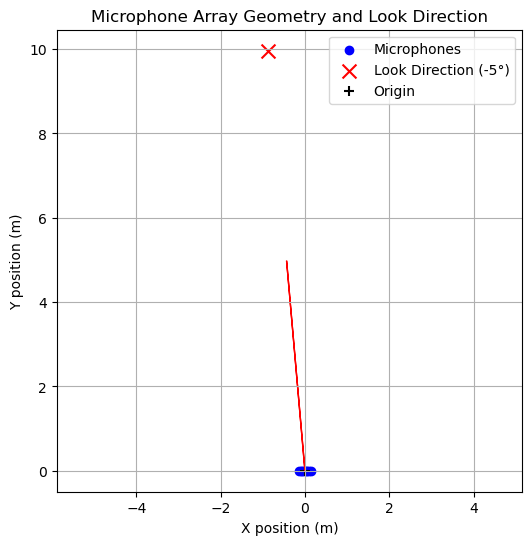


--- Initializing PyTorch MVDR Beamformer ---
PyTorch MVDR Beamformer Initialized on device: cpu

--- Calculating Look Direction Steering Vector (PyTorch) ---
Calculated steering vector tensor for look direction. Shape: torch.Size([8, 129]), Device: cpu

--- Starting PyTorch Analysis Loop (181 angles) ---
Processed angle 20/181 (-71.0 degrees)
Processed angle 20/181 (-71.0 degrees)
Processed angle 40/181 (-51.0 degrees)
Processed angle 40/181 (-51.0 degrees)
Processed angle 60/181 (-31.0 degrees)
Processed angle 60/181 (-31.0 degrees)
Processed angle 80/181 (-11.0 degrees)
Processed angle 80/181 (-11.0 degrees)
Processed angle 100/181 (9.0 degrees)
Processed angle 100/181 (9.0 degrees)
Processed angle 120/181 (29.0 degrees)
Processed angle 120/181 (29.0 degrees)
Processed angle 140/181 (49.0 degrees)
Processed angle 140/181 (49.0 degrees)
Processed angle 160/181 (69.0 degrees)
Processed angle 160/181 (69.0 degrees)
Processed angle 180/181 (89.0 degrees)

Analysis complete.
Maximum resp

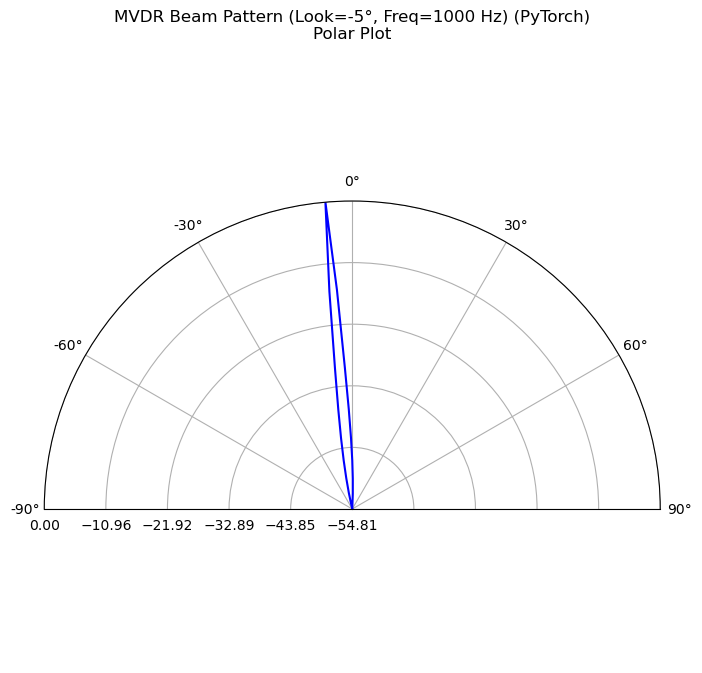

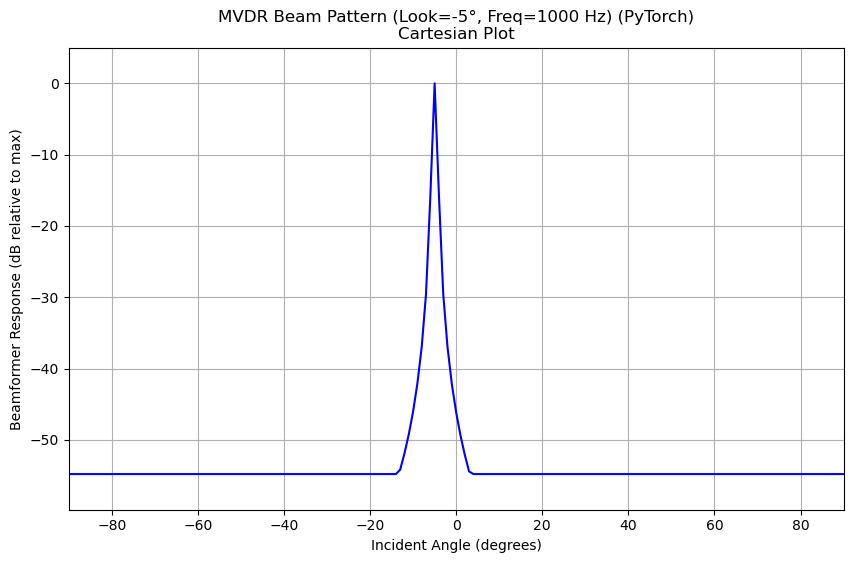


--- Plotting Details for Look Direction ---


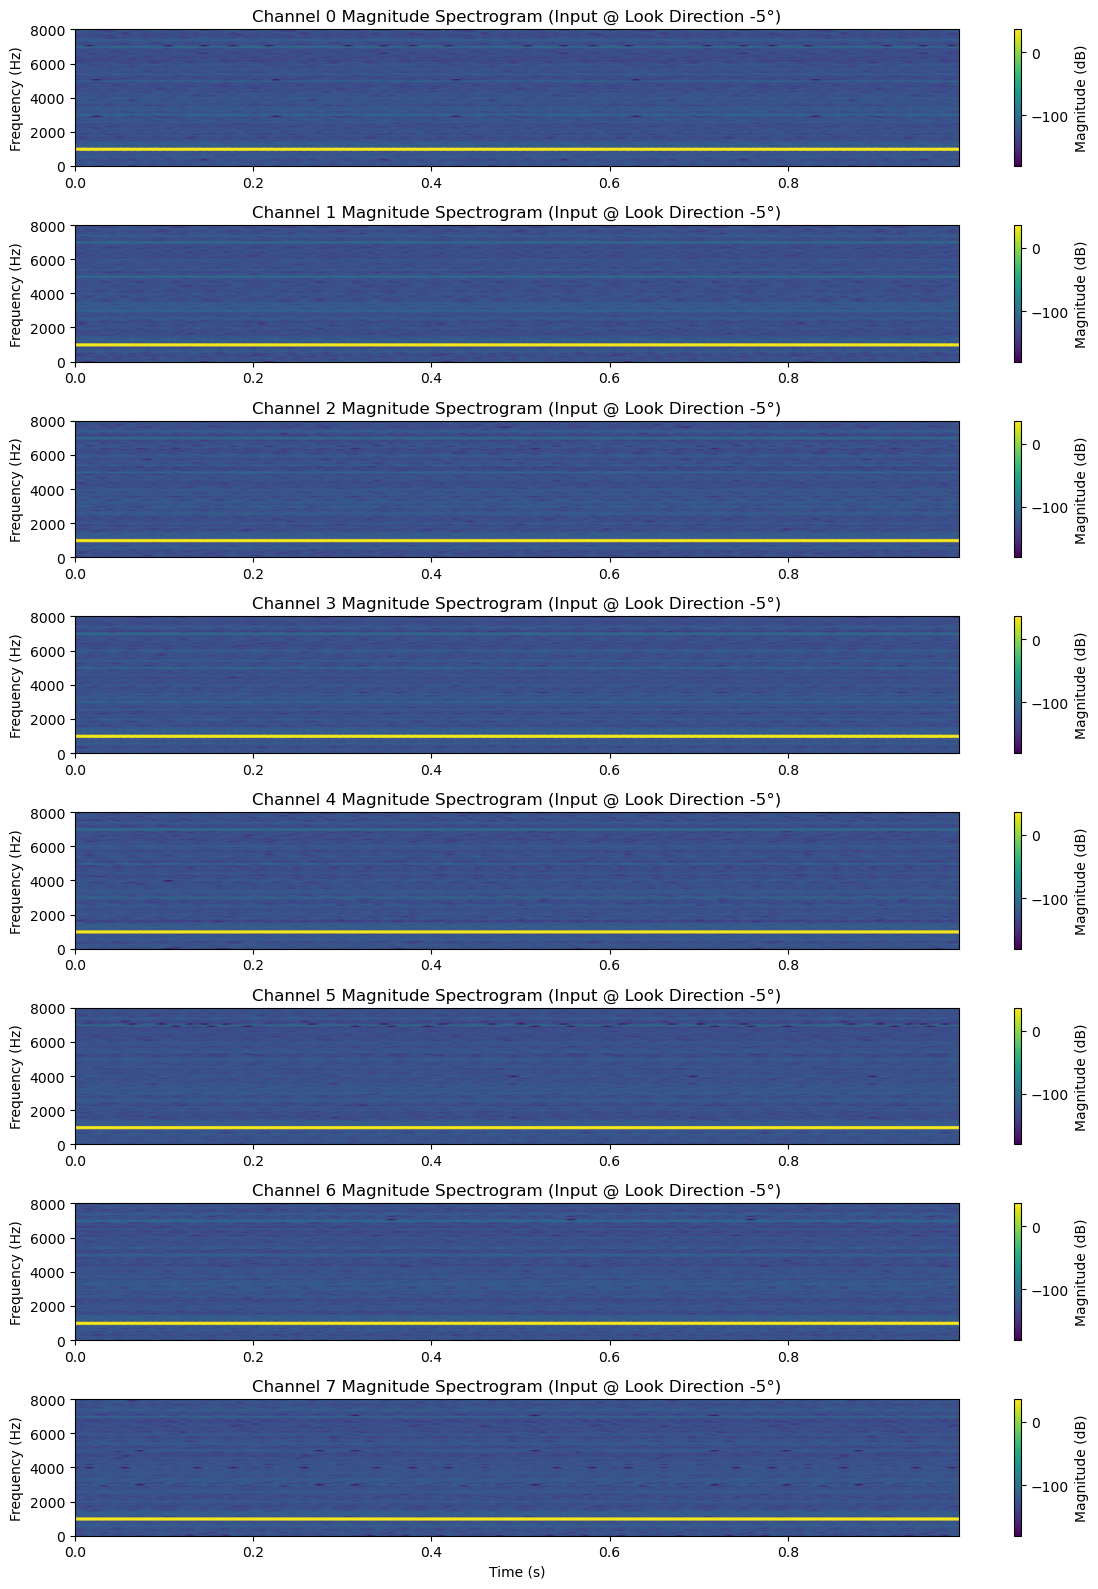

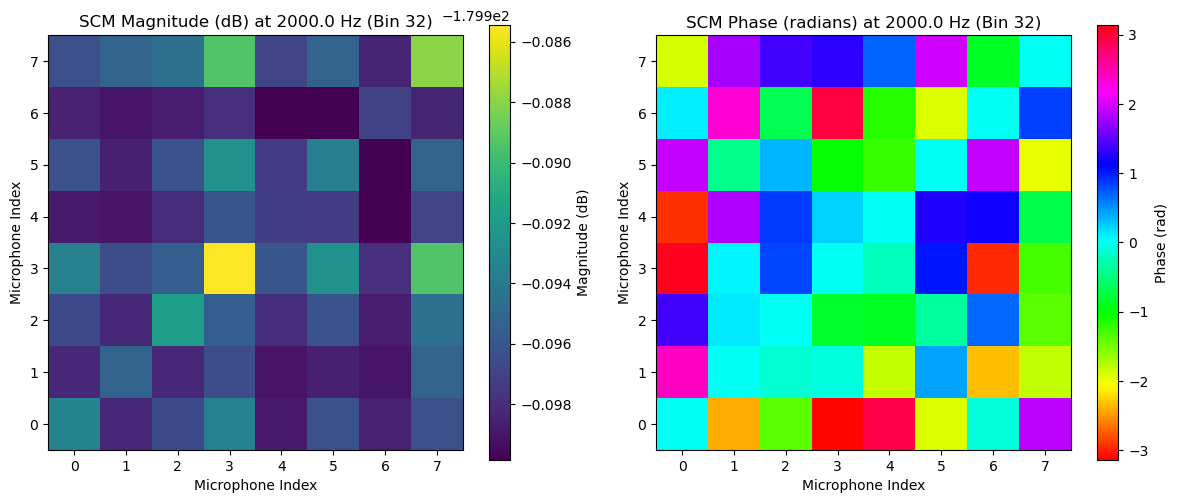

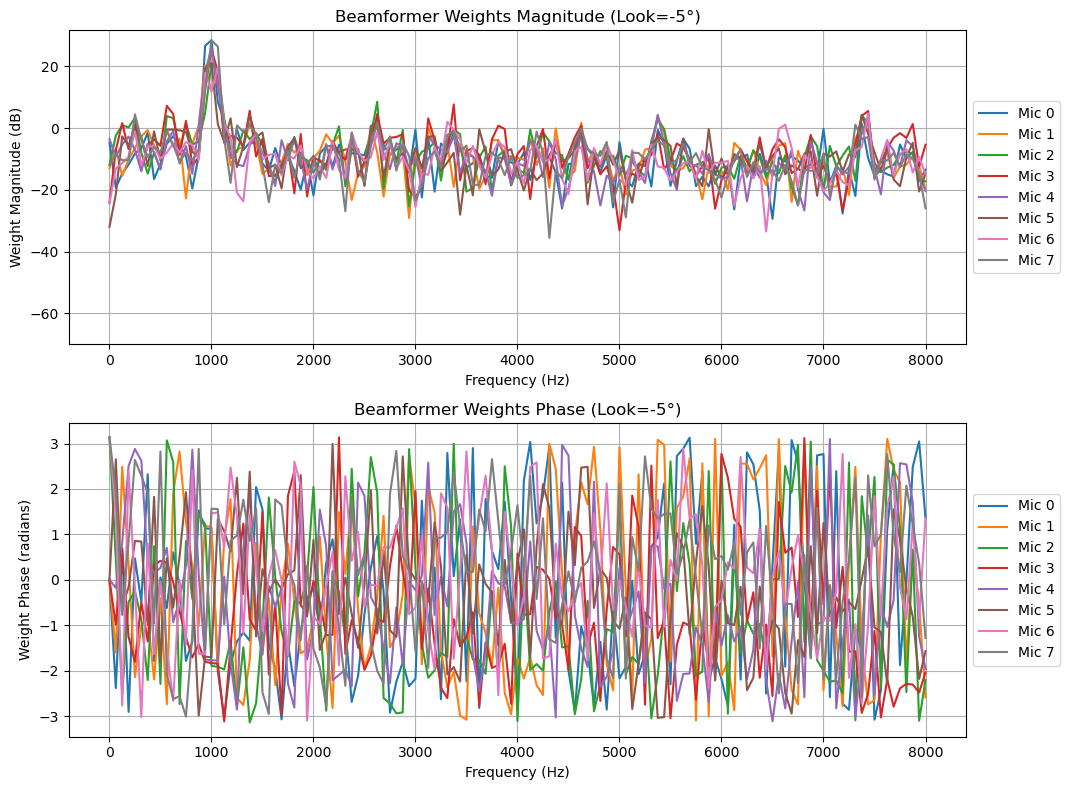


--- Analysis Finished ---


In [14]:
final_output(params)